In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wildlife-classification/benchmark.ipynb
/kaggle/input/wildlife-classification/train_labels.csv
/kaggle/input/wildlife-classification/train_features.csv
/kaggle/input/wildlife-classification/test_features.csv
/kaggle/input/wildlife-classification/submission_format.csv
/kaggle/input/wildlife-classification/train_features/ZJ003277.jpg
/kaggle/input/wildlife-classification/train_features/ZJ002547.jpg
/kaggle/input/wildlife-classification/train_features/ZJ000938.jpg
/kaggle/input/wildlife-classification/train_features/ZJ005086.jpg
/kaggle/input/wildlife-classification/train_features/ZJ010327.jpg
/kaggle/input/wildlife-classification/train_features/ZJ016447.jpg
/kaggle/input/wildlife-classification/train_features/ZJ006555.jpg
/kaggle/input/wildlife-classification/train_features/ZJ007997.jpg
/kaggle/input/wildlife-classification/train_features/ZJ006871.jpg
/kaggle/input/wildlife-classification/train_features/ZJ014354.jpg
/kaggle/input/wildlife-classification/train_features/ZJ011

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# For data preprocessing
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.data import AUTOTUNE

In [3]:
# Define base directory
BASE_DIR = "/kaggle/input/wildlife-classification"

# Define paths
TRAIN_CSV_PATH = os.path.join(BASE_DIR, "train_features.csv")
TEST_CSV_PATH = os.path.join(BASE_DIR, "test_features.csv")
LABELS_CSV_PATH = os.path.join(BASE_DIR, "train_labels.csv")
TRAIN_IMG_DIR = os.path.join(BASE_DIR, "train_features")
TEST_IMG_DIR = os.path.join(BASE_DIR, "test_features")

In [4]:
train_features = pd.read_csv(TRAIN_CSV_PATH)
test_features = pd.read_csv(TEST_CSV_PATH)
train_labels = pd.read_csv(LABELS_CSV_PATH)

# Display first few rows
print(train_features.head())
print(train_labels.head())

         id                     filepath   site
0  ZJ000000  train_features/ZJ000000.jpg  S0120
1  ZJ000001  train_features/ZJ000001.jpg  S0069
2  ZJ000002  train_features/ZJ000002.jpg  S0009
3  ZJ000003  train_features/ZJ000003.jpg  S0008
4  ZJ000004  train_features/ZJ000004.jpg  S0036
         id  antelope_duiker  bird  blank  civet_genet  hog  leopard  \
0  ZJ000000              0.0   1.0    0.0          0.0  0.0      0.0   
1  ZJ000001              0.0   0.0    0.0          0.0  0.0      0.0   
2  ZJ000002              0.0   1.0    0.0          0.0  0.0      0.0   
3  ZJ000003              0.0   0.0    0.0          0.0  0.0      0.0   
4  ZJ000004              0.0   0.0    0.0          0.0  0.0      1.0   

   monkey_prosimian  rodent  
0               0.0     0.0  
1               1.0     0.0  
2               0.0     0.0  
3               1.0     0.0  
4               0.0     0.0  


In [5]:
species_labels = sorted(train_labels.columns.unique())
species_labels

['antelope_duiker',
 'bird',
 'blank',
 'civet_genet',
 'hog',
 'id',
 'leopard',
 'monkey_prosimian',
 'rodent']

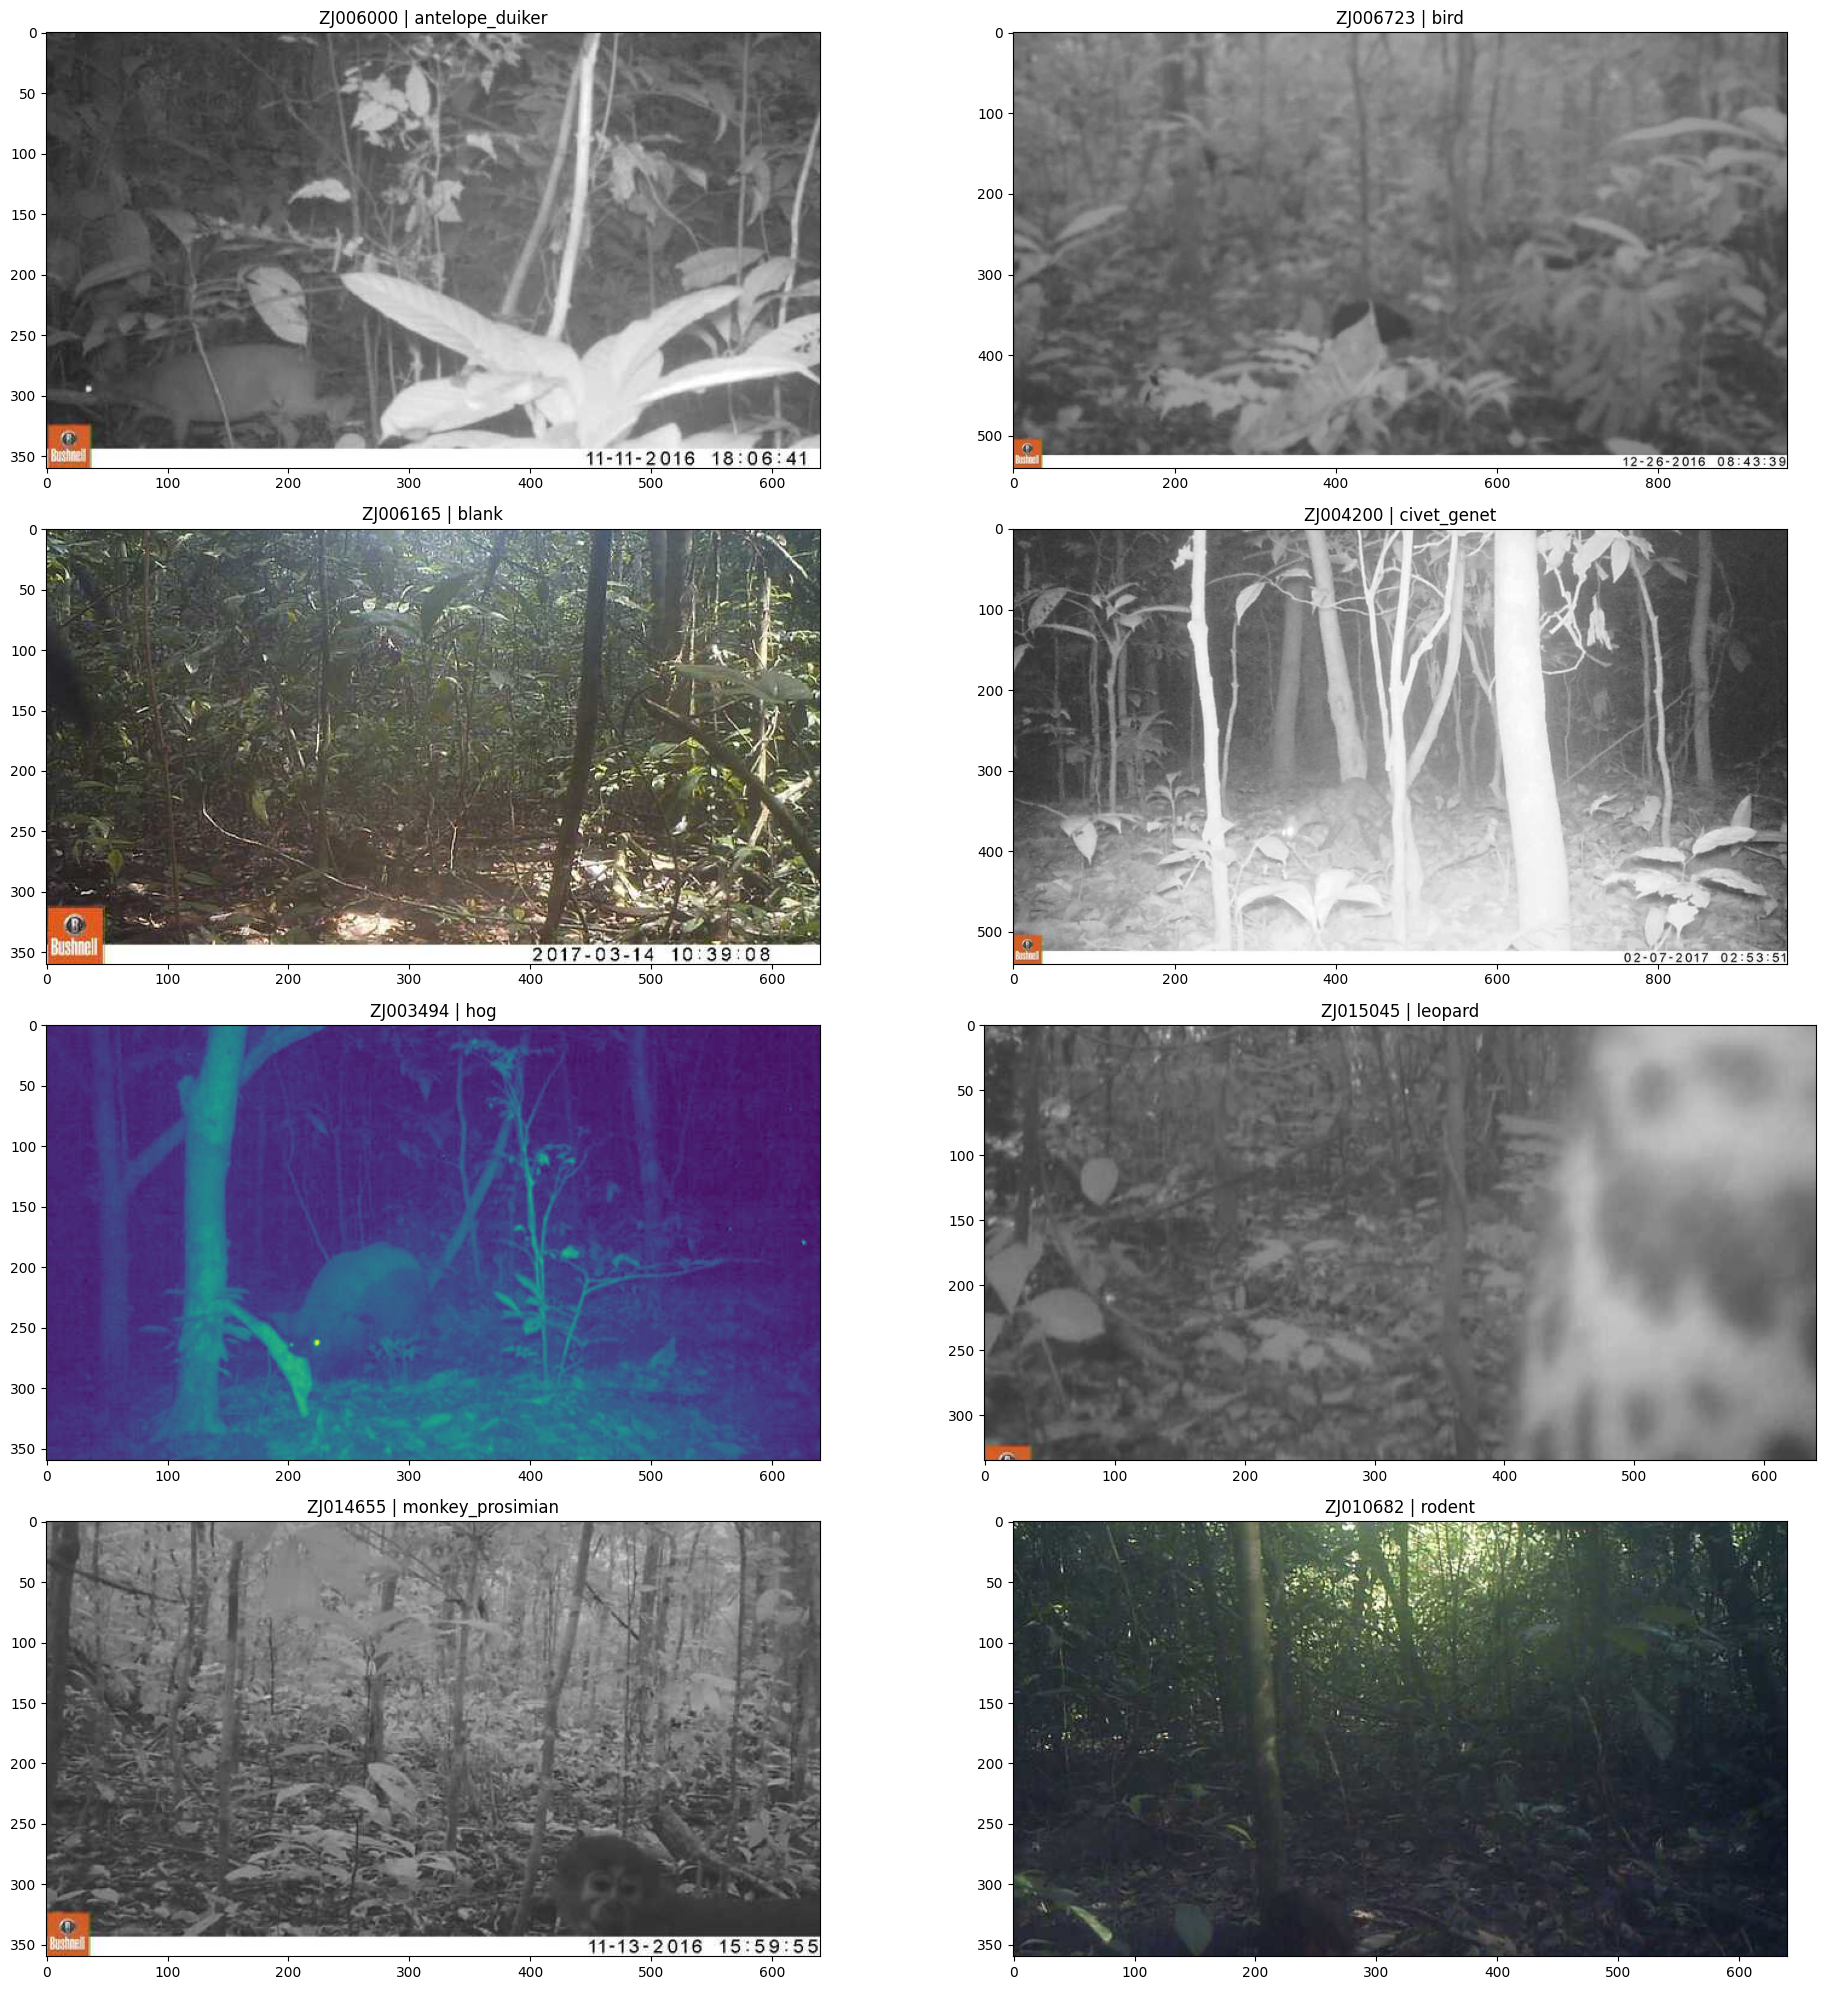

In [6]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

random_state = 42

# Define the correct species labels from train_labels.csv
species_labels = train_labels.columns[1:]  # Exclude 'id' column

# Create a grid with 8 positions, one for each label (7 species + blank)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(20, 20))

# Iterate through each species
for species, ax in zip(species_labels, axes.flat):
    # Get all images for the species
    species_images = train_labels[train_labels[species] == 1]

    # Skip if no images exist for this species
    if species_images.empty:
        ax.set_title(f"No images for {species}")
        ax.axis("off")  # Hide axis if no image is available
        continue

    # Sample one image ID from available images
    img_id = species_images.sample(1, random_state=random_state).id.values[0]
    
    # Get the correct file path
    img_path = os.path.join(BASE_DIR, train_features[train_features["id"] == img_id]["filepath"].values[0])
    
    # Read and plot the image
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(f"{img_id} | {species}")

plt.tight_layout()
plt.show()

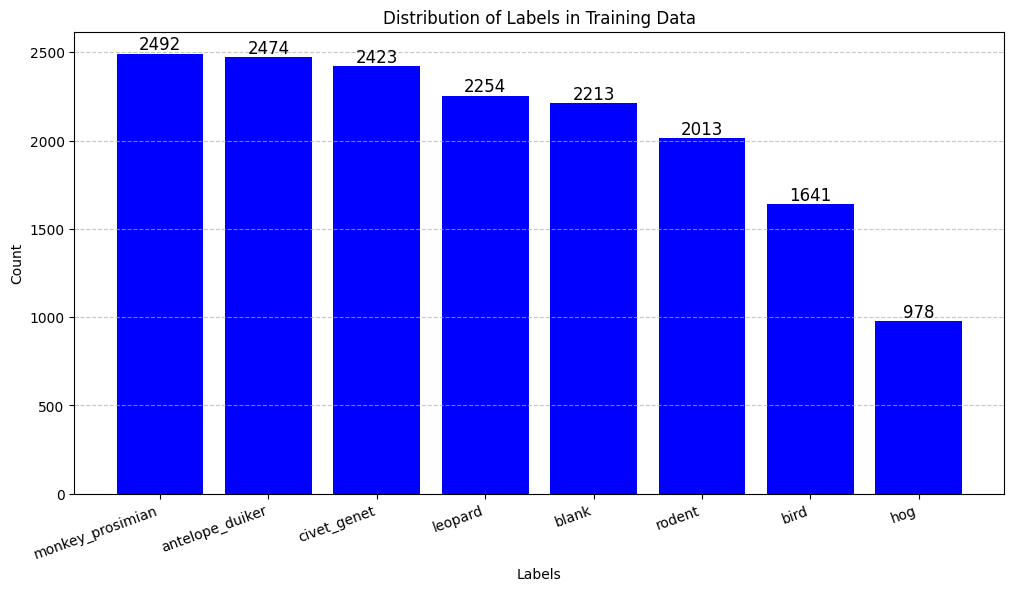

In [7]:
# Ensure we sum only numeric columns
numeric_labels = train_labels.select_dtypes(include=['number'])

# Sum occurrences of each label
label_counts = numeric_labels.sum().sort_values(ascending=False)

# Plot bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(label_counts.index, label_counts.values, color='blue')

# Annotate bars with their values
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', fontsize=12)

# Labels and title
plt.xlabel("Labels")
plt.ylabel("Count")
plt.title("Distribution of Labels in Training Data")
plt.xticks(rotation=20, ha='right')  # Rotate x-axis labels for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()

In [8]:
# Merge train features with labels
df = train_features.merge(train_labels, on="id", how="left")

# Drop rows with missing labels
df.dropna(inplace=True)

# Find the label for each image (the column where the value is 1)
label_columns = train_labels.columns[1:]  # Excluding the 'id' column

# Ensure labels are in one-hot encoded format
labels_one_hot = df[label_columns].to_numpy().astype(np.float32)

In [9]:
# Extract Image Paths
df["image_path"] = df["id"].apply(lambda x: os.path.join(TRAIN_IMG_DIR, f"{x}.jpg"))
image_paths = df["image_path"].values

In [10]:
# Split into Training and Validation Sets
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels_one_hot, test_size=0.2, stratify=labels_one_hot, random_state=42
)

print("Train labels shape:", train_labels.shape)
print("Validation labels shape:", val_labels.shape)

Train labels shape: (13190, 8)
Validation labels shape: (3298, 8)


In [11]:
# Define Constants for EfficientNet
IMG_SIZE = (224, 224)
BATCH_SIZE = 64
AUTOTUNE = tf.data.AUTOTUNE

# Function to Load & Preprocess Images
def load_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  
    image = tf.image.resize(image, IMG_SIZE)  
    image = preprocess_input(image)  # EfficientNet preprocessing
    
    return image, label  # Ensure label is returned

# Define Augmentation 
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomContrast(0.2),
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

# Data Augmentation Function (for Training Only)
def augment(image, label):
    image = data_augmentation(image)  
    return image, label

In [12]:
# Create training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset.map(load_image, num_parallel_calls=AUTOTUNE)  # Load images
train_dataset = train_dataset.map(augment, num_parallel_calls=AUTOTUNE)  # Augment training data
train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Create validation dataset (no augmentation)
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_dataset = val_dataset.map(load_image, num_parallel_calls=AUTOTUNE)  # Load images
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

print("Datasets prepared successfully!")

Datasets prepared successfully!


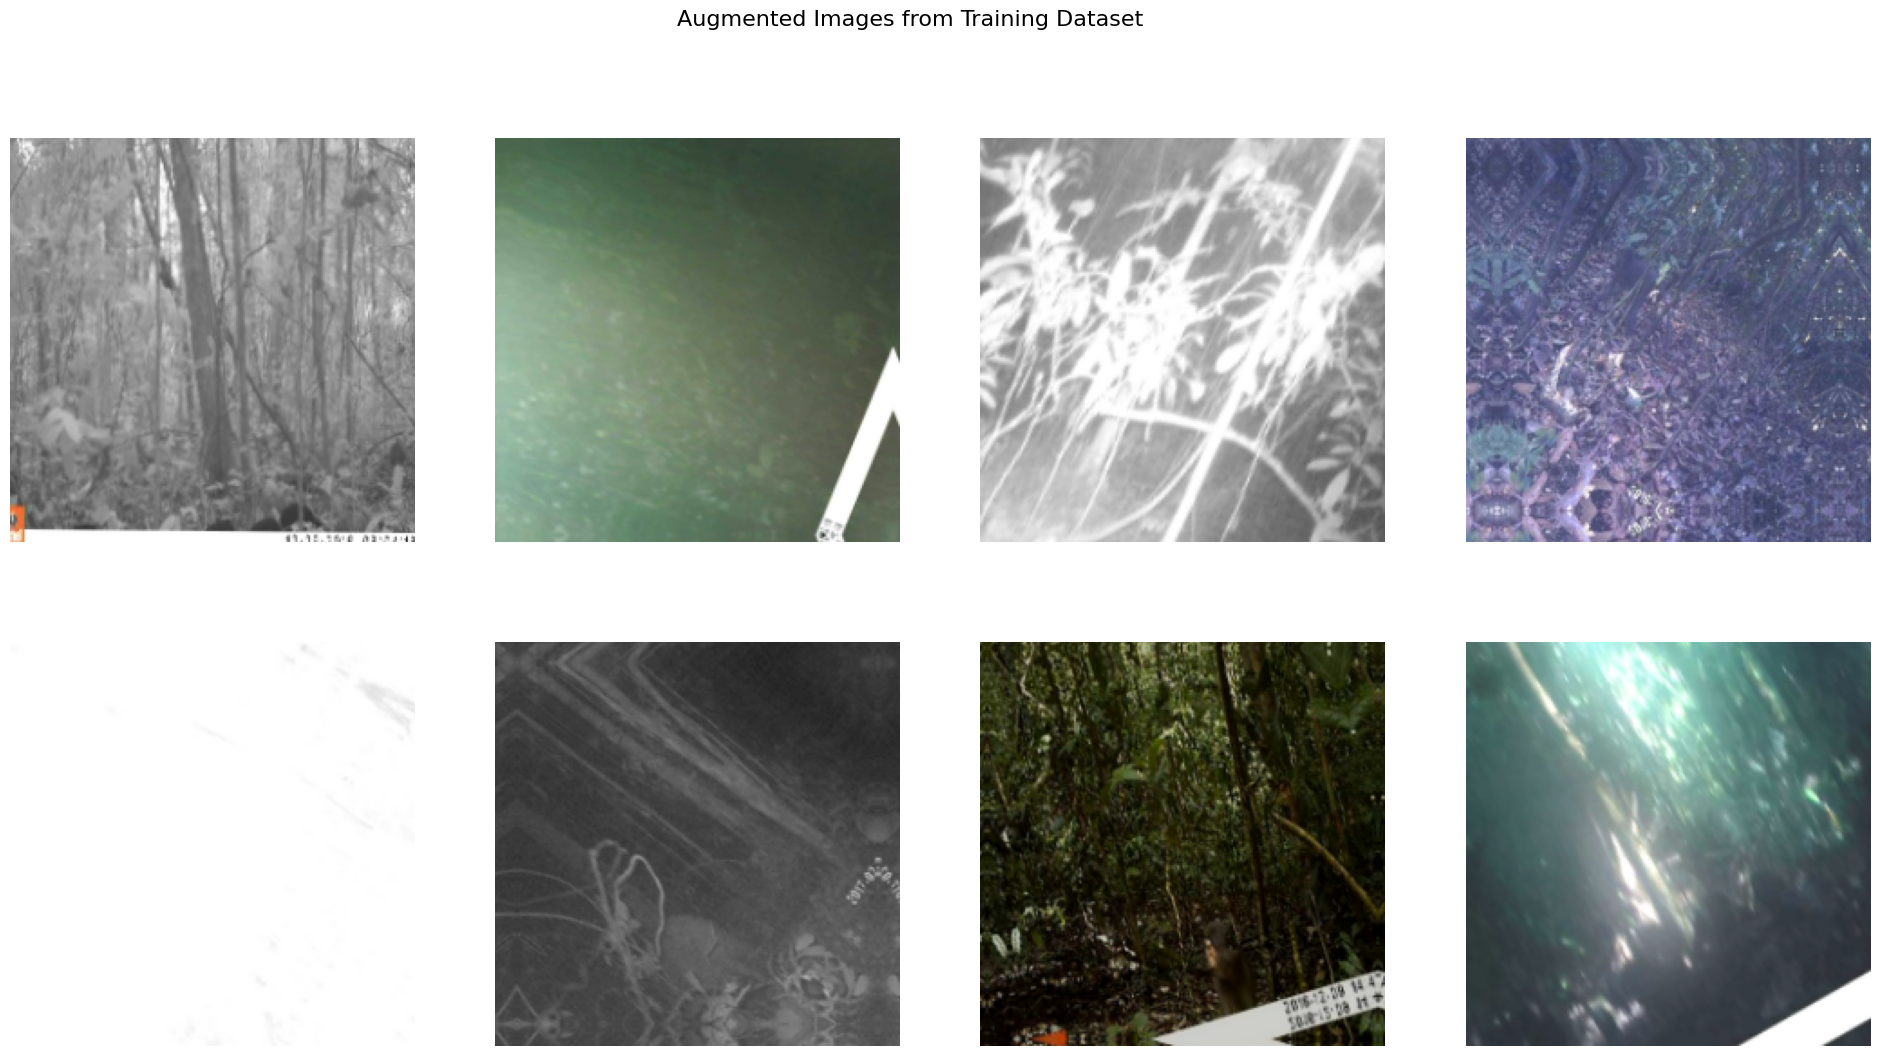

In [13]:
import matplotlib.pyplot as plt

# Fetch a batch of images and labels from the dataset
sample_batch = next(iter(train_dataset))  # Get one batch
sample_images, sample_labels = sample_batch  # Unpack images and labels

# Convert tensor to numpy array
sample_images = sample_images.numpy()

# Define number of images to show
num_images = min(8, sample_images.shape[0])  # Show up to 8 images

# Create subplots
fig, axes = plt.subplots(2, 4, figsize=(24, 12))

for i, ax in enumerate(axes.flat):
    if i < num_images:
        ax.imshow(sample_images[i].astype("uint8"))  # Convert tensor to uint8 image
        ax.axis("off")
    else:
        ax.remove()

plt.suptitle("Augmented Images from Training Dataset", fontsize=16)
plt.show()